# Field boundary mapping in small scale farming using multi-resolution satellite data

The code was developed within a project funded by FAO, aiming at developing automatic workflows for mapping rice field boundaries in small-scale farming, using deep learning neural networks and advanced image processing. We conducted case studies in Cambodia and Vietnam, where rice paddy occupies a large portion of the agricultural area. We are facing two major challenges in the target research areas: (1) the lack of reference data, and (2) the fragmented agricultural areas characterized by very small fields (i.e., less than 1 ha). To overcome them, we used a convolutional deep learning U-Net network, able to achieve accurate segmentation result even with few training images.

## Set up directories and download Keras-unet repository
- Specify the directories where the original images are stored
- Specify the directories where the labeled images are stored
    - 1: Other pixels
    - 2: Field boundary pixels
- Remove .ipynb_checkpoints directories

In [47]:
import os
import numpy as np
import typing
import keras
import tensorflow as tf
from skimage import exposure
from osgeo import gdal
import shutil

# Install keras-unet library for python
# %pip install git+https://github.com/karolzak/keras-unet

BASE_PATH = "/home/jovyan/private/Agricultural_Field_Boundary"
INPUT_PATH = BASE_PATH + "/Training_dataset/"
OUTPUT_PATH = BASE_PATH + "/Networks/fine_tune_UNet5_Sentinel2/FAO_Cambodia_Unet"
IMAGE_PATH = "/Original_FY_MEDIAN"
LABEL_PATH = "/Classified"
INCLUDE_FOLDERS = ["Cambodia"]


LEGEND = {
    1: 'Other',
    2: 'Field Boundary'
}


# Note: .ipynb_checkpoints are generated from the notebook interface
# when removing/adding image samples manually. They should be deleted,
# otherwise the Kernel will be died and forced to restart
for folder in INCLUDE_FOLDERS:
    original = INPUT_PATH + folder + IMAGE_PATH
    classified = INPUT_PATH + folder + LABEL_PATH
    if os.path.exists(f"{original}/.ipynb_checkpoints"):
        shutil.rmtree(f"{original}/.ipynb_checkpoints")
    if os.path.exists(f"{classified}/.ipynb_checkpoints"):
        shutil.rmtree(f"{classified}/.ipynb_checkpoints")



## Load original and labeled images
- Read original and labeled images into two dictionaries
- Use a combination of province and index as key

In [48]:
# ################################################################
# Loading input data
#
# Input data is loaded into two dictionaries:
#
# images: contains the 4-band images. The values are loaded as ints.
# labels: contains 3D arrays in which each pixel is assigned with
#         a label "1" = other and "2" = field boundary
#
# ################################################################


def key_generator(file_name):
    """Generates the key of a file based on the file name. The resulting key is
    a tuple of the province/country as string & the file number index as int,
    e.g. ("gelderland", 29)
    """
    file_name = file_name.lower()
    file_name = file_name.replace("classified_", "")
    file_name = file_name.replace("original_", "")
    file_name = file_name.replace(".tif", "")
    (province, index) = tuple(file_name.split("_"))
    index = int(index)
    return (province, index)


def gtiff_to_array(file_path):
    """Takes a file path and returns a tif file as a 3-dimensional numpy array, width x height x bands."""
    data = gdal.Open(file_path)
    bands = [data.GetRasterBand(i+1).ReadAsArray() for i in range(data.RasterCount)]
    return np.stack(bands, axis=2)


def transform_classification_image(input):
    """Takes the classification image input (in RGB format as 3D array) and
    creates a 2D array out of this. The innermost array expects either values of
    [0, 0, 0] as pixels wihtin a field, or [1, 1, 1] as boundary pixels, or 'no data'
    pixels outside a field, since this is the colouring we assigned to the
    classified images.

    :param input: 3D input image (classification)
    :return: 2D array image with labels 1 for 'other' and 2 for 'field_boundaries'
    """

    # Out of the 3D input array it takes the "max" element out of the array
    # This function is just called to transform the 3D array to a 2D array.
    result = np.reshape(np.max(input, axis=2), (input.shape[0], input.shape[1], 1))
    # Now the array consists of pixels with values "0" or "1". We transform
    # each value, that is larger than 0 (i.e. 1) and assign the label "2" to
    # it. Each other element (i.e. 0 and no data) will get assigned the label "1".
    result = np.where(result > 0, 2, 1)
    return result


# Dictionaries which contain the input data
images = {}
labels = {}

# Iterate through defined folders and load all image data into the dictionaries
# image_data and label_data. Images can be accessed with (<place>, <index>)
for folder in INCLUDE_FOLDERS:
    original = INPUT_PATH + folder + IMAGE_PATH
    classified = INPUT_PATH + folder + LABEL_PATH
    for f in os.listdir(original):
        value = gtiff_to_array(original + "/" + f)
        key = key_generator(f)
        images[key] = value

    for f in os.listdir(classified):
        value = gtiff_to_array(classified + "/" + f)

        # Transform the classification image from RGB to labels "1" and "2"
        value = transform_classification_image(value)
        key = key_generator(f)
        labels[key] = value

    print(f"{folder} image tiles: {len(os.listdir(original))}")
    print(f"{folder} label tiles: {len(os.listdir(classified))}")

print(f"Shape of sample image file: {list(images.values())[0].shape}")
print(f"Shape of sample label file: {list(labels.values())[0].shape}")
print(f"Total number of image & label tiles: {len(images)}")

Cambodia image tiles: 2
Cambodia label tiles: 2
Shape of sample image file: (768, 768, 4)
Shape of sample label file: (768, 768, 1)
Total number of image & label tiles: 2


## Image normalization: scale image data to range between 0 and 1
- Sample based normalization
- Overall normalization
    - using maxima and minima
    - using means and standard deviations

In [49]:
# ################################################################
# Normalizing images
#
# Normalizing all input images into values in the interval [0, 1].
# All bands are normalized seperately, which means, the min & max
# of each band is calculated based on each band of the image data.
# ################################################################

def normalize_array_1(arr):
    """Takes a 3D array as input, iterates over the bands and normalizes those.

    :param arr: input array (original image data) 
    :return: normalized data with values between 0 and 1
    """
    arr_norm = np.zeros(arr.shape, dtype=np.float32)

    for i in range(arr.shape[2]):
        min = arr[:, :, i].min()
        max = arr[:, :, i].max()
        arr_norm[:,:,i] = (arr[:,:,i] - min) / (max - min)
    return arr_norm

def normalize_array_2(arr, minimum, maximum):
    """Takes a 3D array as input, iterates over the bands and normalizes those.

    :param arr: input array (original image data)
    :param minimum and maximum: minima and maxima of all the images in each band.
    :return: normalized data with values between 0 and 1
    """

    arr_norm = np.zeros(arr.shape, dtype=np.float32)

    for i in range(arr.shape[2]):
        arr_norm[:,:,i] = (arr[:,:,i] - minimum[i]) / (maximum[i] - minimum[i])
    return arr_norm

def normalize_array_3(arr, mean, sd):
    """Takes a 3D array as input, iterates over the bands and normalizes those.

    :param arr: input array (original image data)
    :param mean and sd: mean and sdandard deviation of all the images in each band.
    :return: normalized data with values between 0 and 1
    """
    arr_norm = np.zeros(arr.shape, dtype=np.float32)

    for i in range(arr.shape[2]):
        arr_norm[:,:,i] = (arr[:,:,i] - mean[i]) / sd[i]
    return arr_norm

def get_feature_mins_maxs(images):
    """get the minima and maxima per band for all image data
    :param image: list of image data
    :return: minima and maxima per band
    """
    features_mins = []
    features_maxs = []
    arr = np.array(images)
    for i in range(arr.shape[-1]):
        features_mins.append(np.min(arr[:, :, :, i]))
        features_maxs.append(np.max(arr[:, :, :, i]))
    return np.array(features_mins), np.array(features_maxs)

features_mins, features_maxs = get_feature_mins_maxs(list(images.values()))
for k, v in images.items():
    images[k] = normalize_array_2(v, features_mins, features_maxs)
    # images[k] = normalize_array_1(v)
    print(f"Performed normalization of {k[0]}_{k[1]}")


Performed normalization of cambodia_13
Performed normalization of cambodia_14


## Training-test split

In [50]:
# ################################################################
# Split input data into training & test set
#
# Takes the entire input and splits the data into a training data
# set and test data set. The proportions are defined as follows:
#
#     Size_training = Size_input * RELATIVE_TRAINING_SIZE
#     Size_test = Size_input * (1 - RELATIVE_TRAINING_SIZE)
#
# The resulting data sets are mutually exclusive, e.g.:
#     Set_training | Set_test = Set_input
#     Set_training & Set_test = []
#
#     Remark: (| = Union, & = Intersection, [] = empty set)
#
# ################################################################

import random

# Constants to sample test & training set
SEED = 34
RELATIVE_TRAINING_SIZE = 0.5

def calculate_k(n):
    """Splitting the input data into training & test requires a variable called
    'k'. 'k' defines the size of the subset of a variable.

    :param n: number of images
    :return: k
    """
    k = RELATIVE_TRAINING_SIZE * n
    return int(k)

# Create a generator with predefined SEED
random_generator = random.Random(SEED)

# Entire set of keys
keys = set(images.keys())

# Split key_set into x_train_keys and x_test_keys
keys_train = set(random_generator.sample(keys, calculate_k(len(keys))))
keys_test = keys - keys_train

print(keys_test)
print(keys_train)

# Generate dictionaries with training data
x_train_dict = { k : images[k] for k in keys_train }
y_train_dict = { k : labels[k] for k in keys_train }

# Generate dictionaries with test data
x_test_dict = { k : images[k] for k in keys_test }
y_test_dict = { k : labels[k] for k in keys_test }

# Print key set of each set
print(x_train_dict.keys())
print(x_test_dict.keys())
print(list(x_train_dict.keys())[0])

{('cambodia', 14)}
{('cambodia', 13)}
dict_keys([('cambodia', 13)])
dict_keys([('cambodia', 14)])
('cambodia', 13)


## Visualize the image sample data (original or label)

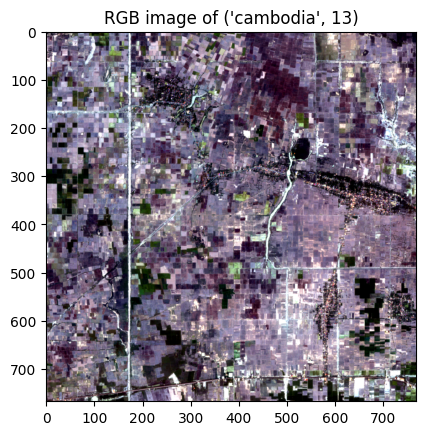

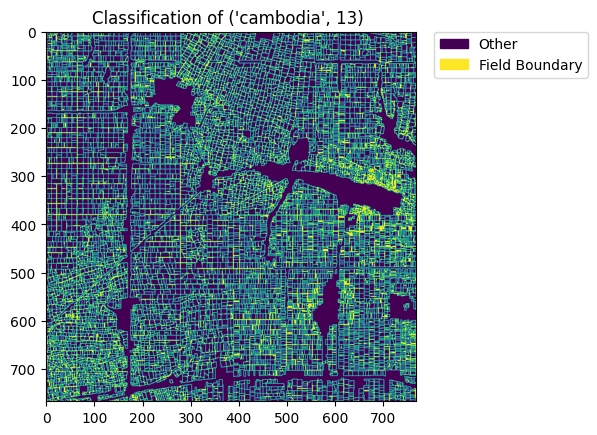

In [51]:
# ################################################################
# Visualize some sample input data
#
# Helps to verify that the data is correct and also supports the
# thinking process if trying to debug the program.
# ################################################################

from matplotlib import patches, pyplot


def visualize_labels(arr, title, legend_labels):
    """Visualize the labels prepared from the reference images.

    :param arr: 3D array of an image to display
    :param title: Title to assign to the output
    :param label: Labels to use in the legend
    """
    fig = pyplot.figure()
    a = fig.add_subplot(1, 1, 1)
    a.set_title(title)

    values = np.unique(arr.ravel())
    im = pyplot.imshow(arr[:, :, 0])

    # get the colors of the values according to the color map used by imshow
    colors = [im.cmap(im.norm(v)) for v in values]

    # Generate a legend
    legend = []
    for i, v in enumerate(values):
        legend.append(patches.Patch(
            color=colors[i],
            label=legend_labels[v]
        ))
    pyplot.legend(handles=legend, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


def visualize_data(arr, title):
    """Visualize the satellite image data.

    :param arr: Input image (4 bands, the first 3 will be printed)
    :param title: Title of the plot
    """
    data = arr[:, :, 0:-1]
    data = data.astype(np.float32)

    # perform stretching for better visualization
    for i in range(data.shape[2]):
        p2, p98 = np.percentile(data[:, :, i], (2, 98))
        data[:, :, i] = exposure.rescale_intensity(data[:, :, i], in_range = (p2, p98))
    fig = pyplot.figure()
    a = fig.add_subplot(1,1,1)
    a.set_title(title)
    pyplot.imshow(data)


key = list(x_train_dict.keys())[0]
visualize_data(images[key], f"RGB image of {key}")
visualize_labels(labels[key], f"Classification of {key} ", LEGEND)


## Divide the raw image into patches of a smaller size
- Define patch size
- Concatenate patches into x_train (original) and y_train (label)
- Visualize a patch for confirmation

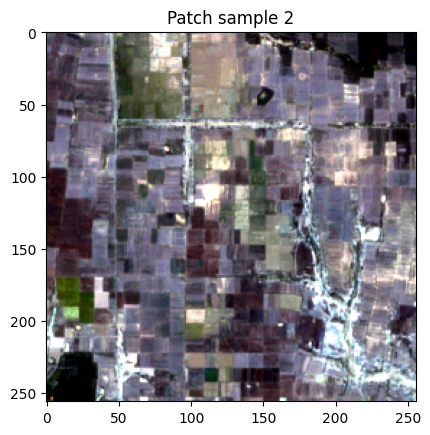

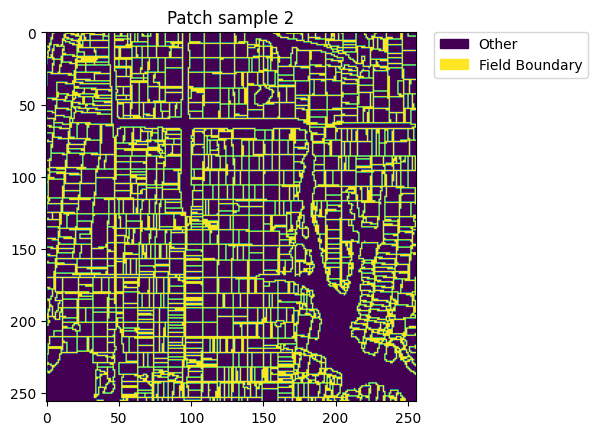

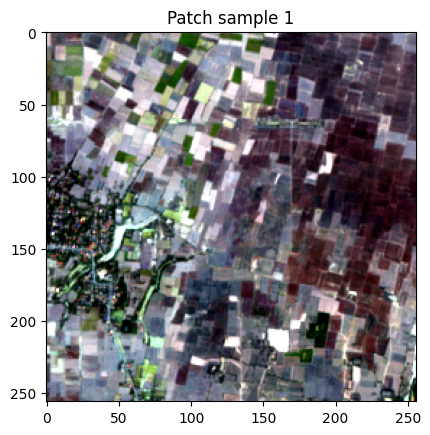

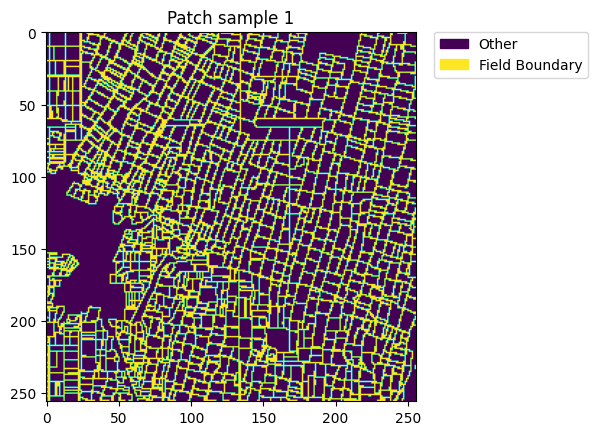

In [52]:
# ################################################################
# Generating patches of the input data
#
# A convolutional neural network can be trained more efficiently,
# if the patches that are fed to the network are smaller. Thus,
# this section will cut a large input image into
# patches of a smaller size (PATCHSIZE)
# ################################################################

# In the case of U-Net the patch size should be the nth power of 2
# to allow for the use of the predefined layers. N is determined by the number
# of layers contained in the network.
PATCHSIZE = 256
NBANDS = list(images.values())[0].shape[-1]

def perform_gridwise_sampling(img, patchsize):
    """Takes an input array with 3 dimensions and returns a 4 dimension array
    where the outermost dimension consists of patches out of the image.
    Patches are cut gridwise out of a grid with patchsize x patchsize pixels

    :param img: 3D input array of an image
    :param patchsize: The size of a patch
    :return: input image split into multiple patches in 4D array
    """
    x = int(img.shape[0] / patchsize)
    y = int(img.shape[1] / patchsize)
    n = img.shape[2]
    s = patchsize

    patches = np.zeros(
        shape=(0, s, s, n),
        dtype=img.dtype
    )

    for row in range(x):
        for col in range(y):
            # create patch, expand the dimension and add it to the samples
            patch = img[row * s : (row + 1) * s, col * s : (col + 1) * s, :]
            patch = np.expand_dims(patch, axis=0)
            patches = np.concatenate((patches, patch), axis=0)

    return patches

x_train = np.zeros(shape=(0, PATCHSIZE, PATCHSIZE, NBANDS), dtype=np.float32)
y_train = np.zeros(shape=(0, PATCHSIZE, PATCHSIZE, 1), dtype=np.float32)

for k in x_train_dict.keys():
    # Create patches
    x_patches = perform_gridwise_sampling(x_train_dict[k], PATCHSIZE)
    y_patches = perform_gridwise_sampling(y_train_dict[k], PATCHSIZE)

    # Insert patches into x_train and y_train data set
    x_train = np.concatenate((x_train, x_patches), axis=0)
    y_train = np.concatenate((y_train, y_patches), axis=0)

# Print a sample set of the data set to verify, samples are created properly
for sample_size in [2, 1]:
    visualize_data(x_train[sample_size], f"Patch sample {sample_size}")
    visualize_labels(y_train[sample_size], f"Patch sample {sample_size}", LEGEND)


## Setting up the network
- Create a tensorflow session
- Define a ModelHistory class to handle metadata
- Define helper functions for training the network

In [53]:
# ################################################################
# Prerequisites for the network
#
# Includes a few helper functions which will be used to create and
# evaluate the network, the training and the accuracy.
# ################################################################

import importlib, h5py
import pickle
from tensorflow.compat.v1.keras.backend import set_session
from tensorflow.python.keras import backend as K
importlib.reload(h5py)

# Tensorflow configuration
config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.2
set_session(tf.compat.v1.Session(config=config))


def train(model, data: np.ndarray, labels: np.ndarray, epochs: int, batch_size: int = 64, validation_split: float = 0.01, verbosity: int = 2):
    """Fit training and label data into a model of a network

    :param model: Network
    :param data: Input data (satellite images)
    :param labels: Classified input data (classified images)
    :param epochs: The number of epochs/iterations
    :param batch_size: The batch size per epoch
    :param validation_split: relative split of the validation set
    :param verbosity: Verbosity level of the output [default: 2] (0 = silent, 1 = progress bar, 2 = line per epoch)
    :return: Training history
    """
    history = model.fit(
    x=data,
    y=labels,
    batch_size=batch_size,
    epochs=epochs,
    verbose=verbosity,
    validation_split=validation_split
    )
    return history


# ################################################################
# Helper functions - import/export of network
#
# These two functions help to export the network and import it.
# That allows to skip the training at a later stage.
# ################################################################

class ModelHistory:
    """Just a small container class to hold relevant information of a trained
    model.
    """

    def __init__(self, uuid, name, model, history, readme):
        """Create a new instance of this class
        :param uuid: A unique identifier of the network
        :param name: The networks name
        :param model: The pretrained model
        :param history: The training history of the model
        :param readme: A small readme with a summary of training parameters
        """
        self.uuid = uuid
        self.name = name
        self.model = model
        self.history = history
        self.readme = readme


def get_file_names(uuid, name):
    """Generates four file names for the model, weights and history file and
    the networks readme.

    File name order of returned tuple:
        * readme
        * model
        * weights
        * history

    :param uuid: Universal unique identifier of a trained network
    :param name: The networks name
    :return: Tuple with files in the order mentioned above
    """
    base = f"{OUTPUT_PATH}/{str(uuid)}-{name}"

    f_readme = f"{base}-readme.txt"
    f_model = f"{base}-model.h5"
    f_weights = f"{base}-weights.h5"
    f_history = f"{base}-history"

    return (f_readme, f_model, f_weights, f_history)


def export_model(m: ModelHistory):
    """If a model is sufficiently trained, it can be exported. This allows to
    simply save the models state and the training history. Whenever one want to
    use the model the next time, the training can be skipped, since the trained
    model can just be imported from files.

    :param model_history: The trained model and history to be stored
    """
    f_readme, f_model, f_weights, f_history = get_file_names(m.uuid,m.name)

    # save readme
    with open(f_readme, 'w') as f:
        f.write(m.readme)
    print(f"Exported README: {f_readme}")

    # save models & weights
    m.model.save(f_model)
    print(f"Exported model: {f_model}")
    m.model.save_weights(f_weights)
    print(f"Exported weights: {f_weights}")

    # save history
    with open(f_history, "wb") as f:
        pickle.dump(m.history, f)
    print(f"Exported history: {f_history}")

# def import_model(uuid, name):
#     """Previously exported models can be imported with this funciton.
#     :param uuid: The networks uuid
#     :param name: The networks name
#     :return: Instance of ModelHistory
#     """
#     f_readme, f_model, f_weights, f_history = get_file_names(uuid, name)

#     # Load readme
#     with open(f_readme, 'r') as f:
#         readme = "".join(f.readlines())
#     print(f"Imported README: {f_readme}")

#     # Load model & weights
#     model = tf.keras.models.load_model(f_model,custom_objects={"gap_loss": gap_loss})
#     print(f"Imported model: {f_model}")
#     model.load_weights(f_weights)
#     print(f"Imported weights: {f_weights}")

#     # Load history
#     with open(f_history, 'rb') as f:
#         history = pickle.load(f)
#     print(f"Imported history: {f_history}")

#     return ModelHistory(uuid, name, model, history, readme)

def import_model(uuid, name):
    """Previously exported models can be imported with this function.
    :param uuid: The network's UUID
    :param name: The network's name
    :return: Instance of ModelHistory
    """
    f_readme, f_model, f_weights, f_history = get_file_names(uuid, name)

    # Load readme
    with open(f_readme, 'r') as f:
        readme = "".join(f.readlines())
    print(f"Imported README: {f_readme}")
    
    # Register the custom loss function with a name
    tf.keras.utils.get_custom_objects()["custom_loss"] = gap_loss

    # Load model & weights
    model = tf.keras.models.load_model(f_model, custom_objects={"custom_loss": gap_loss})
    print(f"Imported model: {f_model}")
    model.load_weights(f_weights)
    print(f"Imported weights: {f_weights}")

    # Load history
    with open(f_history, 'rb') as f:
        history = pickle.load(f)
    print(f"Imported history: {f_history}")

    return ModelHistory(uuid, name, model, history, readme)


def to_categorical_4d(y: np.ndarray, nc: int):
    """Convert a reclassed ground truth array to one-hot encoding

    Data structure is as follows:

    4D array, consisting of the different patches, rows, columns of pixels.
    The innermost array has as many elements as labels/classes exist.
    Each element in the array represents a class, e.g:
        label[x, y, z, 0] = label 1
        label[x, y, z, 1] = label 2

    Only the correct label is activated (i.e. has the value 1)

    :param y: labeled input array
    :param nc: number of classes
    """
    Y = np.zeros((y.shape[0], y.shape[1], y.shape[2], nc), dtype=int)

    # Activating labels

    # Label 1 = other
    Y[:, :, :, 0] = np.where(y[:, :, :, 0] == 1, 1, 0)
    # Label 2 = field boundaries
    Y[:, :, :, 1] = np.where(y[:, :, :, 0] == 2, 1, 0)

    return Y

## Network builder functions
- Base model is satellite_unet
- A different number of layers is passed to the base model


In [54]:
# ################################################################
# Network builder functions
#
# Dynamic builder function for unet (layer 1 to 5).
# ################################################################

# from keras.layers import Activation, BatchNormalization, Convolution2D, LeakyReLU, Reshape, ZeroPadding2D
# from keras.models import Sequential
# from tensorflow.keras.optimizers import SGD, Adam
from keras_unet.models import satellite_unet

def build_unet(
    x: int,
    y: int,
    bands: int,
    labels: int,
    layers: int = 2,
) -> tf.keras.Model:
    """Create  a model of the popular U-Net network.

    :param x: Number of rows (x-shape)
    :param y: Number of columns (y-shape)
    :param bands: Number of bands (z-shape)
    :param lables: Number of labels to predict with the network; Should be 2 or 3
    :return: Model of the corresponding U-Net network
    """
    model = satellite_unet(
        input_shape=(x, y, bands),
        num_classes=labels,
        output_activation="softmax",
        num_layers=layers
    )
    return model

def build_unet2(
    x: int,
    y: int,
    bands: int,
    labels: int,
) -> tf.keras.Model:
    """Wrapper function to build an UNet with 2 layers
    """
    return build_unet(x, y, bands, labels, layers=2)

def build_unet3(
    x: int,
    y: int,
    bands: int,
    labels: int,
) -> tf.keras.Model:
    """Wrapper function to build an UNet with 3 layers
    """
    return build_unet(x, y, bands, labels, layers=3)

def build_unet4(
    x: int,
    y: int,
    bands: int,
    labels: int,
) -> tf.keras.Model:
    """Wrapper function to build an UNet with 5 layers
    """
    return build_unet(x, y, bands, labels, layers=4)

def build_unet5(
    x: int,
    y: int,
    bands: int,
    labels: int,
) -> tf.keras.Model:
    """Wrapper function to build an UNet with 5 layers
    """
    return build_unet(x, y, bands, labels, layers=5)

def build_network(name: str) -> typing.Callable:
    """Builds a new network, based on the networks name
    :param name: The networks name
    :return: The builder function of the corresponding network.
    """
    if name.lower() == "unet2":
        return build_unet2
    elif name.lower() == "unet3":
        return build_unet3
    elif name.lower() == "unet4":
        return build_unet4
    elif name.lower() == "unet5":
        return build_unet5


## Configure the training run
- Define the execution modes
- Get the network UUID
- Choose the execution mode
- Define other hyper-parameters for the training

In [55]:
# ################################################################
# Fixed constants
#
# This code block does not need to be changed.
# ################################################################

import uuid

# Execution mode options
SKIP = 0                # Do nothing, e.g. just reloading other variables
TRAIN_NEW = 1           # Create a new model & train it with given parameters
LOAD_AND_TRAIN = 2      # Load existing model & train
LOAD = 3                # Load existing model w/o training

# Bands and classes do not need to be changed.
NUMBER_BANDS = 4
NUMBER_CLASSES = 2

# Constants relevant for the network & training
NETWORK_UUID = str(uuid.uuid1())


In [56]:
# ################################################################
# Training configuration
#
# These are the variable parameters of the configuration. Change
# them to your prefered configuration and check the results of the
# training at the end of the execution.
# ################################################################


# Define here the exection mode
# Remark: The option LOAD_AND_TRAIN and LOAD require a given UUID and network
#         name. Make sure those are given below
# Allowed Options:
#    * SKIP
#    * TRAIN_NEW
#    * LOAD_AND_TRAIN
#    * LOAD
# exec_mode = LOAD_AND_TRAIN
exec_mode = TRAIN_NEW


# If you set the exec_mode to work with a pretrained network, then define the
# network's UUID and the network's name here. These two parameters are crucial
# to assign the right file's to the network.
load_from_uuid = "6c0f7e24-a85a-11ec-938c-02420a0001f1"
load_from_name = "UNet5"
if exec_mode == TRAIN_NEW:
    load_from_uuid = ""
    load_from_name = ""


# Decide whether you want to save the training configuration after the training
# is successful.
# Allowed Options:
#    * True
#    * False
SAVE_AFTER_EXEC = True


# Set the name of the executed network here. Defines the network type
# Allowed values:
#     * UNet2
#     * UNet3
#     * UNet4
#     * UNet5
NETWORK_NAME = "UNet5"

# Increases the amount of epochs per training run. An epoch is in principle an
# iteration over the training data. As larger the number of epochs, as better
# the training results. But if the epochs are too large you risk to overfit the
# network.
NUMBER_EPOCHS = 60


# Define the batch size with this parameter.
BATCH_SIZE = 256

# Set here the relative size of the validation set. Generally, this value should
# be small, but if you have a small input data set, you might want to increase
# the validation split.
VALIDATION_SPLIT = 0.01


# Chose the network's optimizer.
# Allowed values:
#    * SGD
#    * Adam
NETWORK_OPTIMIZER = "Adam"

# Define the hyper parameters of the SGD optimizer here.
# Ignore these parameters if you want to train with an Adam optimizer.
SGD_LEARNING_RATE = 0.0015
SGD_MOMENTUM = 0.9

# Define the hyper parameters of the Adam optimizer here.
# Ignore these parameters if you want to train with an SGD optimizer.
ADAM_LEARNING_RATE = 0.001
ADAM_BETA_1 = 0.9
ADAM_BETA_2 = 0.999
ADAM_EPSILON = 1e-06


## Build the network and train
- Write the description in the readme files
- Define loss functions
- Build the network depending on the execution mode chosen
- Compile and train

In [57]:
# ################################################################
# Training of the model
#
# This section covers the actual training of the model and ensures
# the results are exported and ready for import. The configuration
# have happened in previous code blocks.
# ################################################################


from skimage.morphology import skeletonize

from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()


import tensorflow as tf
from skimage.morphology import skeletonize

# This function will be called to build the model
model_builder = build_network(NETWORK_NAME)
if exec_mode in [LOAD, LOAD_AND_TRAIN]:
    NETWORK_UUID = load_from_uuid
    NETWORK_NAME = load_from_name

# Just build the configuration description of the network
readme = f"""
Training configuration
================================
Network
    UUID:               {NETWORK_UUID}
    Name:               {NETWORK_NAME}
    Optimizer:          {NETWORK_OPTIMIZER}

Parameters
    Bands:              {NUMBER_BANDS}
    Classes:            {NUMBER_CLASSES}
    Epochs:             {NUMBER_EPOCHS}
    Batch Size:         {BATCH_SIZE}
"""

if NETWORK_OPTIMIZER == "SGD":
    readme += f"""
Optimizer (if SGD)
    Learning Rate:      {SGD_LEARNING_RATE}
    Momentum:           {SGD_MOMENTUM}
    """

if NETWORK_OPTIMIZER == "Adam":
    readme += f"""
Optimizer (Adam)
    Learning Rate:      {ADAM_LEARNING_RATE}
    Beta 1:             {ADAM_BETA_1}
    Beta 2:             {ADAM_BETA_2}
    Epsilon:            {ADAM_EPSILON}
    """

readme += f"""
Execution summary
    Patches:            {x_train.shape[0]}
    Validation Split:   {VALIDATION_SPLIT}
    Resolution (px):    {x_train.shape[1]}x{x_train.shape[2]}
    Bands:              {x_train.shape[3]}
    Classes:            {y_train.shape[3]}
"""

readme += "\n"
readme += "Training Set:\n    "
readme += "\n    ".join([f"({k[0]}, {k[1]})" for k in x_train_dict.keys()])

readme += "\n"
readme += "Test Set:\n    "
readme += "\n    ".join([f"({k[0]}, {k[1]})" for k in x_test_dict.keys()])

# Optimizer
if NETWORK_OPTIMIZER == "Adam":
    OPTIMIZER = tf.keras.optimizers.Adam(
        learning_rate=ADAM_LEARNING_RATE,
        beta_1=ADAM_BETA_1,
        beta_2=ADAM_BETA_2,
        epsilon=ADAM_EPSILON
    )
elif NETWORK_OPTIMIZER == "SGD":
    OPTIMIZER = tf.keras.optimizers.SGD(
        learning_rate=SGD_LEARNING_RATE,
        momentum=SGD_MOMENTUM
    )

    # Define loss functions
def weighted_bincrossentropy(true, pred, weight_zero = 1, weight_one = 0.25):
    """
    Calculates weighted binary cross entropy. The weights are fixed.
    This can be useful for unbalanced catagories.
    Adjust the weights here depending on what is required.
    
    For example if there are 10x as many positive classes as negative classes,
        if you adjust weight_zero = 1.0, weight_one = 0.1, then false positives 
        will be penalized 10 times as much as false negatives.
    """
    true = true.astype(np.float64)
    pred = pred.astype(np.float64)
    # calculate the binary cross entropy
    bin_crossentropy = keras.backend.binary_crossentropy(true, pred)
    # apply the weights
    weights = true * weight_one + (1. - true) * weight_zero
    weighted_bin_crossentropy = weights * bin_crossentropy 

    return keras.backend.mean(weighted_bin_crossentropy)

def tversky(y_true, y_pred, smooth=1, alpha=0.7):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1 - y_pred_pos))
    false_pos = K.sum((1 - y_true_pos) * y_pred_pos)
    return (true_pos + smooth) / (true_pos + alpha * false_neg + (1 - alpha) * false_pos + smooth)


def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true, y_pred)


def focal_tversky_loss(y_true, y_pred, gamma=0.75):
    tv = tversky(y_true, y_pred)
    return K.pow((1 - tv), gamma)

def gap_loss(y_true, y_pred, weight_zero, weight_one, K):
    y_true_binary = tf.argmax(y_true, axis=-1)
    y_pred_softmax = tf.nn.softmax(y_pred, axis=-1)
    y_pred_binary = tf.argmax(y_pred_softmax, axis=-1)

    def skeletonize_2d(image):
        def skeletonize_fn(image_np):
            skeleton_np = skeletonize(image_np)
            return skeleton_np.astype(image_np.dtype)

        skeleton = tf.numpy_function(skeletonize_fn, [image], image.dtype)
        skeleton.set_shape(image.shape)
        return skeleton

    # Skeletonize the y_true_binary tensor
    y_true_skeleton = skeletonize_2d(y_true_binary)

    # Add batch dimension to y_true_skeleton
    y_true_skeleton = tf.expand_dims(y_true_skeleton, axis=0)

    # Convert y_true_binary to one-hot encoding
    y_true_binary_one_hot = tf.one_hot(y_true_binary, depth=2)

    neighborhood = tf.image.extract_patches(
        y_true_skeleton, sizes=[1, 9, 9, 1], strides=[1, 1, 1, 1], rates=[1, 1, 1, 1], padding='SAME'
    )
    N = tf.reduce_sum(neighborhood, axis=(1, 2, 3)) - 1
    W = tf.map_fn(lambda x: tf.where(tf.not_equal(x, 0), K * x, 0), N)

    bin_crossentropy = tf.keras.losses.binary_crossentropy(
        y_true_binary_one_hot, y_pred_softmax
    )
    weights = (y_true_binary * weight_one) + ((1.0 - y_true_binary) * weight_zero)
    weighted_bin_crossentropy = weights * bin_crossentropy
    weighted_gap_loss = tf.reduce_sum(W * weighted_bin_crossentropy) / (tf.reduce_sum(W) + 1e-7)
    return weighted_gap_loss

# Define the custom loss function
def custom_loss(y_true, y_pred):
    return gap_loss(y_true, y_pred, WEIGHT_ZERO, WEIGHT_ONE, K)

# Register the custom loss function with a name
tf.keras.utils.get_custom_objects()["custom_loss"] = custom_loss


# Process the steps of the required modes
if exec_mode == TRAIN_NEW:
    # Building a new network.
    print(f"Build a new network: {NETWORK_UUID} {NETWORK_NAME}")
    print(x_train.shape)
    model = model_builder(x_train.shape[1], x_train.shape[2], NUMBER_BANDS, NUMBER_CLASSES)
    # model.compile(optimizer=OPTIMIZER, loss='binary_crossentropy', metrics='accuracy')
    WEIGHT_ZERO = 0.25
    WEIGHT_ONE = 1
    K = 1
    model.compile(optimizer=OPTIMIZER, loss=lambda y_true, y_pred: gap_loss(y_true, y_pred, WEIGHT_ZERO, WEIGHT_ONE, K), metrics=['accuracy'])
    y_train = to_categorical_4d(y_train, NUMBER_CLASSES)
    history = train(model, x_train, y_train, NUMBER_EPOCHS, batch_size=BATCH_SIZE, validation_split=VALIDATION_SPLIT).history
    if SAVE_AFTER_EXEC:
        export_model(ModelHistory(
            NETWORK_UUID, NETWORK_NAME, model, history, readme
        ))

elif exec_mode == LOAD:
    # Load existing network from files
    print(f"Loaded existing network: {NETWORK_UUID} {NETWORK_NAME}")
    m = import_model(NETWORK_UUID, NETWORK_NAME)
    readme = m.readme
    model = m.model
    history = m.history
    # Print configuration README before (possible) training
    print(readme)
    if SAVE_AFTER_EXEC:
        export_model(ModelHistory(
            NETWORK_UUID, NETWORK_NAME, model, history, readme
        ))

elif exec_mode == LOAD_AND_TRAIN:
    # Load existing network from files
    print(f"Loaded existing network: {NETWORK_UUID} {NETWORK_NAME}")
    m = import_model(NETWORK_UUID, NETWORK_NAME)
    readme = m.readme
    model = m.model
    history = m.history
    # Print configuration README before (possible) training
    print(readme)
    WEIGHT_ZERO = 0.25
    WEIGHT_ONE = 1
    K = 1
    #model.compile(optimizer=OPTIMIZER, loss=lambda y_true, y_pred: gap_loss(y_true, y_pred, WEIGHT_ZERO, WEIGHT_ONE, K), metrics=['accuracy'])
    model.compile(optimizer=OPTIMIZER, loss=custom_loss, metrics=['accuracy'])
    #model.compile(optimizer=OPTIMIZER, loss='binary_crossentropy', metrics='accuracy')
    y_train = to_categorical_4d(y_train, NUMBER_CLASSES)
    history = train(model, x_train, y_train, NUMBER_EPOCHS, batch_size=BATCH_SIZE, validation_split=VALIDATION_SPLIT).history
    if SAVE_AFTER_EXEC:
        export_model(ModelHistory(
            NETWORK_UUID, NETWORK_NAME, model, history, readme
        ))

else:
    print("Remark: Execution mode is 'SKIP'; Nothing executed in this code block")

Build a new network: 7fbd6f86-3a2f-11ee-813a-02420a01187d UNet5
(9, 256, 256, 4)
Epoch 1/60
1/1 - 12s - loss: 195762.5000 - accuracy: 0.4959 - val_loss: 21260.0625 - val_accuracy: 0.4014 - 12s/epoch - 12s/step
Epoch 2/60
1/1 - 1s - loss: 178408.5469 - accuracy: 0.4833 - val_loss: 27259.2852 - val_accuracy: 0.6216 - 1s/epoch - 1s/step
Epoch 3/60
1/1 - 1s - loss: 170179.5000 - accuracy: 0.4513 - val_loss: 27067.9570 - val_accuracy: 0.6134 - 1s/epoch - 1s/step
Epoch 4/60
1/1 - 1s - loss: 165390.5938 - accuracy: 0.4234 - val_loss: 23002.3516 - val_accuracy: 0.5296 - 1s/epoch - 1s/step
Epoch 5/60
1/1 - 1s - loss: 163061.1094 - accuracy: 0.3991 - val_loss: 21221.0391 - val_accuracy: 0.4323 - 1s/epoch - 1s/step
Epoch 6/60
1/1 - 1s - loss: 162196.2812 - accuracy: 0.3887 - val_loss: 20944.4238 - val_accuracy: 0.4035 - 1s/epoch - 1s/step
Epoch 7/60
1/1 - 1s - loss: 161473.6875 - accuracy: 0.4025 - val_loss: 21376.1406 - val_accuracy: 0.4460 - 1s/epoch - 1s/step
Epoch 8/60
1/1 - 1s - loss: 160237

[link text](https://)

## Plot metrics versus epoch
- Training loss vs validation loss
- Training accuracy vs validation accuracy

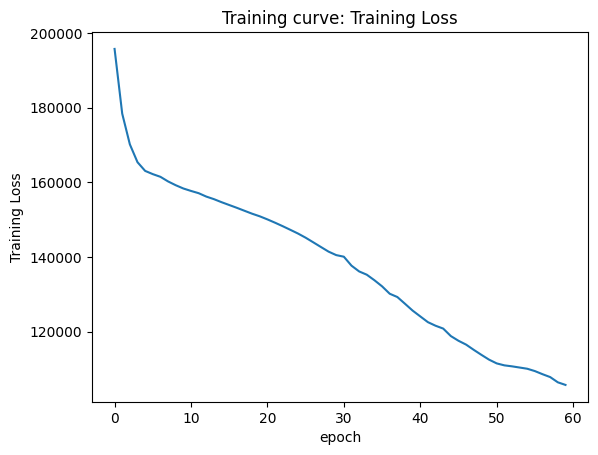

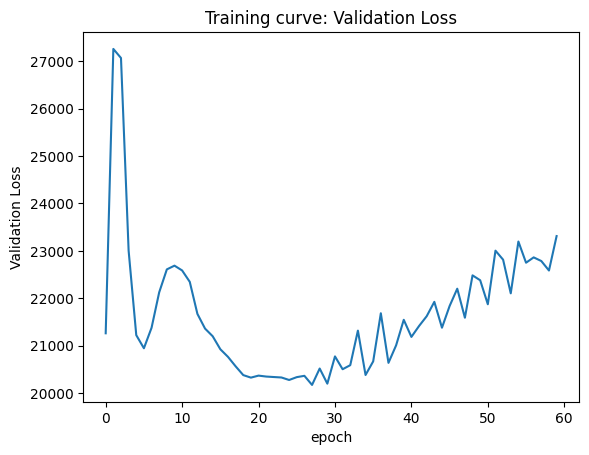

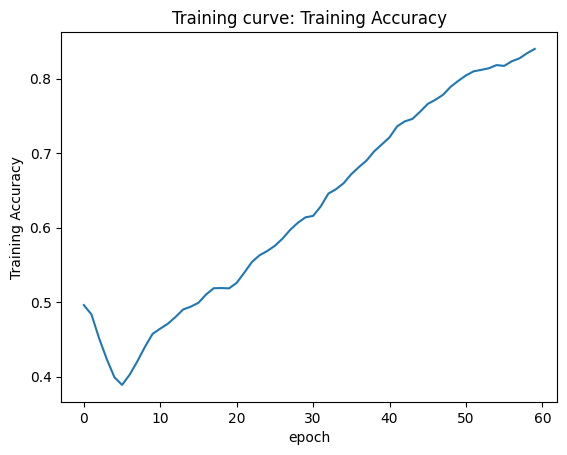

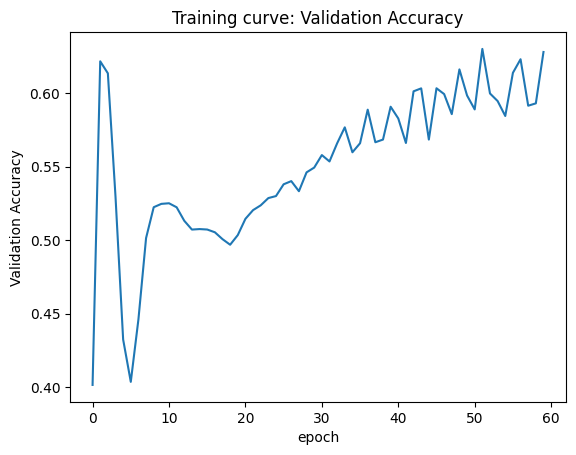

In [58]:
# ################################################################
# Learning curves
#
# To verify whether the algorithm is working, we can plot learning
# curves. Two functions are plotted:
#
#   * loss function
#   * error rate function
# ################################################################


def generate_plot(metrics, title: str):
    """Generates a plot of a specific parameters
    :param p: Name of the model training paramter
    :param title: Optional title for the y-label and plot name
    """
    if title is None:
        title = p

    pyplot.plot(metrics)
    pyplot.title(f"Training curve: {title}")
    pyplot.ylabel(title)
    pyplot.xlabel("epoch")
    pyplot.show()

# Loss function
generate_plot(history["loss"], "Training Loss")
generate_plot(history["val_loss"], "Validation Loss")
# Accuracy function
generate_plot(history["accuracy"], "Training Accuracy")
generate_plot(history["val_accuracy"], "Validation Accuracy")
